# Forecasting Multiple Seasonal Periods using Dynamic Harmonic Regression: An Introduction
_Joe Brillantes, 18 Jan 2023, R User Group - Philippines_

_Significant portions of this notebook came from https://otexts.com/fpp2/ and https://otexts.com/fpp3/_

## Analytics Objective

_Forecast half-hourly electricty demand (dependent variable) in the state of New South Wales in Australia given half-hourly recorded temperature, holidays, and day-of-week and half-hour-of-day seasonal periods._

## Dynamic Harmonic Regression Models

### (Time Series) Regression Models

* "\[We\] forecast the time series of interest $y$ assuming that it has a linear relationship with other time series $x$" (https://otexts.com/fpp3/regression.html).

* "\[Regression\] models of the form $y_t = β_0 + β_1 x_{1,t} + ⋯ + β_k x_{k,t} + ε_t$, where 
  * $y_t$ is a linear function of the $k$ predictor variables ($x_{1,t},…,x_{k,t}$), and 
  * $ε_t$ is usually assumed to be an uncorrelated error term (i.e., it is white noise)" (https://otexts.com/fpp3/dynamic.html).

### Dynamic Regression Models
* Dynamic regression models are __(time series) regression models__ where the error from the regression is allowed to contain autocorrelation (https://otexts.com/fpp3/dynamic.html).
* "\[Regression\] models of the form 
  * $y_t = β_0 + β_1 x_{1,t} + ⋯ + β_k x_{k,t} + η_t$, where 
    * $y_t$ is a linear function of the $k$ predictor variables ($x_{1,t},…,x_{k,t}$), and 
    * $η_t$ is usually assumed to be an error term that follows an ARIMA model 
  * $(1−ϕ_1B−⋯−ϕ_pB^p) (1−B)^d η_t = c + (1 + θ_1B + ⋯ + θ_qB^q) ε_t$, where 
    * $(1−ϕ_1B−⋯−ϕ_pB^p)$ is AR($p$), 
    * $(1−B)^d$ is $d$ differences, 
    * $(1 + θ_1B + ⋯ + θ_qB^q)$ is MA($q$), and
    * $ε_t$ is usually assumed to be an uncorrelated error term (i.e., it is white noise)" (https://otexts.com/fpp3/dynamic.html).
* $(1−ϕ_1B−⋯−ϕ_pB^p) (1−B)^d η_t = c + (1 + θ_1B + ⋯ + θ_qB^q) ε_t$ is in back-shift notation, where <br> $B$ is the backshift operator (https://otexts.com/fpp3/backshift.html).


### Dynamic Harmonic Regression Models

* Dynamic harmonic regression models are __dynamic regression models__ where the seasonal patterns are "modelled using Fourier terms" (https://otexts.com/fpp3/dhr.html).
* "The advantages of this approach are: 
  * it allows any length seasonality;
  * for data with more than one seasonal period, Fourier terms of different frequencies can be included;
  * the smoothness of the seasonal pattern can be controlled by K, the number of Fourier sine and cosine pairs – the seasonal pattern is smoother for smaller values of K;
  * the short-term dynamics are easily handled with a simple ARMA error.
* The only real disadvantage (compared to a seasonal ARIMA model) is that the seasonality is assumed to be fixed — the seasonal pattern is not allowed to change over time. But in practice, seasonality is usually remarkably constant so this is not a big disadvantage except for long time series" (https://otexts.com/fpp3/dhr.html).
* Fourier terms are alternatives to using seasonal dummy variables (https://otexts.com/fpp3/useful-predictors.html).

## Loading Packages

In [1]:
installOrLoadPackage <- function(listOfPackages) {
    repository <- 'https://cloud.r-project.org/'
    for (package in listOfPackages) {
        if (package %in% row.names(installed.packages()) == TRUE) {
            update.packages(package, dependecies = TRUE, repos=repository)
        } else {
            install.packages(package, repos=repository)
        }
        require(package, character.only = TRUE)
    }
}
installOrLoadPackage(c('tidyverse','tsibble','lubridate','feasts','fable'))

Loading required package: tidyverse

Warning message:
"package 'tidyverse' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.4     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Warning message:
"package 'tibble' was built under R version 4.0.5"
Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'readr' was built under R version 4.0.3"
Warning message:
"package 'purrr' was built under R version 4.0.3"
Warning message:
"package 'dplyr' was built under R version 4.0.5"
Warning message:
"package 'stringr' was built under R version 4.0.3"
Warning message:
"package 'forcats' was built under R version 4.0.5"
-- Conflicts ---------------------------------------------------------------------

## Glimpse of the Data

### Demand

The half-hourly demand of electricity of the Australian states of New South Wales (NSW), Queensland (QLD), South Australia (SA), Tasmania (TAS), and Victoria (VIC) was in https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. The files were all named "demand.csv". To distinguish the "demand.csv" of a state from all other states, each "demand.csv" was in the folder for each state.

Each "demand.csv" file had 4 column headers: "Date", "Period", "OperationalLessIndustrial", "Industrial". The dates were integers. Each date had 48 periods indicating that the demand was recorded every half-hour. "OperationalLessIndustrial" contained the actual measurement of electricity demand.

### Temperature

Similarly, the recorded temperatures of the Australian states were also found in https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. The files were all named "temperature.csv". Each "temperature.csv" of a state was in the folder of that state.

Each "temperature.csv" file had 3 column headers: "Date", "Period", "Temp". The each date was also an integer with 48 periods. "Temp" contained the measurement of temperature.

### Holidays

The files that contained the holidays for each state were all named "holidays.txt", and were in the folder of each state. Each file had no column header, and contained a series of dates indicating the dates of the holidays.

In [2]:
# First 6 lines of https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/NSW2015/demand.csv
# "Date","Period","OperationalLessIndustrial","Industrial"
# 37257,1,5714.045004,1513.954996
# 37257,2,5360.189078,1515.810922
# 37257,3,5014.835118,1509.164882
# 37257,4,4602.755516,1507.244484
# 37257,5,4285.179828,1506.820172

# First 6 lines of https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/NSW2015/temperature.csv
# "Date","Period","Temp"
# 36526,1,16.8
# 36526,2,16.6
# 36526,3,16.4
# 36526,4,16.3
# 36526,5,16.2

# First 5 lines of https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/NSW2015/holidays.txt
# 1/01/2000
# 26/01/2000
# 21/04/2000
# 22/04/2000
# 23/04/2000

## Getting the Data

### Demand and Temperature

The read_csv function read each of the csv files indicated by a list from either paste0(dirs,"/demand.csv") or paste0(dirs,"/temperature.csv"). The map_dfr function bound each of the tibble outputted by the read_csv into a single tibble. The .id argument recorded from which tibble (outputted by the read_csv) each row came from, and gave the column header "State". The column "State" was mutated to replace the integer recorded by the .id argument to the corresponding state in the "states" vector. The column "Date" was also mutated to convert the integer to its corresponding date in YYYY-MM-DD format. The resulting tibble was assigned to either "demands" object for the electricity demand, or to "temperatures" object for the temperatures.

### Holidays

The read_csv function read each of the csv files indicated by a list from paste0(dirs,"/holidays.txt"). The "col_names = FALSE" argument instructed the read_csv function to expect that the files did not have any column header. The map_dfr function bound each of the tibble outputted by the read_csv into a single tibble. The .id argument recorded from which tibble (outputted by the read_csv) each row came from, and gave the column header "State".

The column "State" was transmuted to replace the integer recorded by the .id argument to the corresponding state in the "states" vector. The column "Date" was also transmuted to convert the date in character format to date datatype; the dmy() function indicated that the vector X1 contains characters in d/m/y format. The resulting tibble was assigned to "holdiays" object.

_The code in the next 2 cells is from https://robjhyndman.com/hyndsight/electrictsibbles/._

In [3]:
repo <- "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/"
states <- c("NSW","QLD","SA","TAS","VIC")
dirs <- paste0(repo, states, "2015")

# Read demand data
demands <- paste0(dirs,"/demand.csv") %>%
           as.list() %>%
           map_dfr(read_csv, .id = "State") %>%
           mutate(State = states[as.numeric(State)],
                  Date = as_date(Date, origin = ymd("1899-12-30"))
                 )

# Read temperature data
temperatures <- paste0(dirs,"/temperature.csv") %>% 
                as.list() %>% 
                map_dfr(read_csv, .id = "State") %>% 
                mutate(State = states[as.numeric(State)],
                       Date = as_date(Date, origin = ymd("1899-12-30"))
                      )

# Read holidays data
holidays <- paste0(dirs,"/holidays.txt") %>%
            as.list() %>%
            map_dfr(read_csv, col_names=FALSE, .id="State") %>%
            transmute(State = states[as.numeric(State)],
                      Date = dmy(X1),
                      Holiday = TRUE
                     )

demands[sample(1:nrow(demands), replace=FALSE, size=10),]
temperatures[sample(1:nrow(temperatures), replace=FALSE, size=10),]
holidays[sample(1:nrow(holidays), replace=FALSE, size=10),]


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Date = col_double(),
  Period = col_double(),
  OperationalLessIndustrial = col_double(),
  Industrial = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Date = col_double(),
  Period = col_double(),
  OperationalLessIndustrial = col_double(),
  Industrial = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Date = col_double(),
  Period = col_double(),
  OperationalLessIndustrial = col_double(),
  Industrial = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Date = col_double(),
  Period = col_double(),
  OperationalLessIndustrial = col_double(),
  Industrial = col_doubl

State,Date,Period,OperationalLessIndustrial,Industrial
<chr>,<date>,<dbl>,<dbl>,<dbl>
QLD,2009-07-08,9,3120.8271,1446.1729
SA,2007-06-16,34,1488.6232,270.3768
VIC,2002-02-21,33,4654.9688,1199.0312
NSW,2011-06-30,19,8509.1085,1948.8915
NSW,2010-08-22,22,6939.7652,2038.2348
SA,2009-12-19,14,1027.4257,237.5743
TAS,2011-09-24,13,394.5163,708.4837
QLD,2014-04-18,7,2828.2376,1655.7624
QLD,2006-12-20,28,5486.3032,1397.6968


State,Date,Period,Temp
<chr>,<date>,<dbl>,<dbl>
NSW,2000-08-31,3,13.00
VIC,2007-07-05,27,10.90
QLD,2005-12-10,32,33.60
VIC,2007-11-03,3,15.00
VIC,2003-01-13,44,24.65
TAS,2008-07-05,40,4.20
SA,2011-08-15,8,16.55
NSW,2003-04-22,24,19.90
SA,2008-01-15,27,33.10


State,Date,Holiday
<chr>,<date>,<lgl>
QLD,2004-04-10,TRUE
SA,2011-04-22,TRUE
QLD,2010-12-26,TRUE
TAS,2001-04-25,TRUE
NSW,2004-12-28,TRUE
TAS,2017-11-06,TRUE
VIC,2015-12-25,TRUE
NSW,2006-01-26,TRUE
TAS,2018-12-26,TRUE


In [4]:
# Join demand, temperatures and holidays
aus_elec <- demands %>%
            left_join(temperatures, by = c("State", "Date", "Period")) %>%
            transmute(State,
                      Time = as.POSIXct(Date + minutes((Period-1) * 30)),
                      Period,
                      Date = as_date(Time),
                      DOW = wday(Date, label=TRUE),
                      Demand = OperationalLessIndustrial, 
                      Temperature = Temp,
                     ) %>%
            left_join(holidays, by = c("State", "Date")) %>%
            replace_na(list(Holiday = FALSE))

# Remove duplicates and create a tsibble
aus_elec <- aus_elec %>% 
            filter(!are_duplicated(aus_elec, index=Time, key=State)) %>%
            as_tsibble(index = Time, key=State)

aus_elec[sample(1:nrow(aus_elec), replace=FALSE, size=10),]

# Filter aus_elec to only contain data for NSW and select columns of interest
nsw_elec <- aus_elec %>%
filter(State == "NSW") %>%
select(State, Time, Date, DOW, Demand, Temperature, Holiday)

nsw_elec[sample(1:nrow(nsw_elec), replace=FALSE, size=10),]

State,Time,Period,Date,DOW,Demand,Temperature,Holiday
<chr>,<dttm>,<dbl>,<date>,<ord>,<dbl>,<dbl>,<lgl>
SA,2006-02-02 00:00:00,1,2006-02-02,Thu,1271.7634,16.30,FALSE
SA,2014-11-22 12:30:00,26,2014-11-22,Sat,1068.2530,21.30,FALSE
TAS,2009-01-11 01:00:00,3,2009-01-11,Sun,321.7379,13.80,FALSE
VIC,2004-02-17 11:30:00,24,2004-02-17,Tue,5440.5395,22.75,FALSE
VIC,2008-07-11 15:30:00,32,2008-07-11,Fri,5765.0466,12.80,FALSE
SA,2013-06-07 21:00:00,43,2013-06-07,Fri,1455.6207,12.50,FALSE
SA,2003-09-12 15:00:00,31,2003-09-12,Fri,1308.4582,15.70,FALSE
TAS,2012-02-16 01:30:00,4,2012-02-16,Thu,339.9535,20.30,FALSE
NSW,2005-06-01 18:00:00,37,2005-06-01,Wed,9820.4792,14.50,FALSE


State,Time,Date,DOW,Demand,Temperature,Holiday
<chr>,<dttm>,<date>,<ord>,<dbl>,<dbl>,<lgl>
NSW,2011-02-28 19:30:00,2011-02-28,Mon,7796.642,23.60,FALSE
NSW,2008-11-02 10:30:00,2008-11-02,Sun,6589.963,19.95,FALSE
NSW,2010-08-31 00:30:00,2010-08-31,Tue,6554.316,13.75,FALSE
NSW,2014-04-08 13:30:00,2014-04-08,Tue,6821.661,22.60,FALSE
NSW,2005-05-25 11:30:00,2005-05-25,Wed,7743.618,17.85,FALSE
NSW,2009-02-06 14:00:00,2009-02-06,Fri,11978.477,27.70,FALSE
NSW,2007-06-20 04:00:00,2007-06-20,Wed,5704.648,8.60,FALSE
NSW,2004-02-11 00:30:00,2004-02-11,Wed,5946.116,24.20,FALSE
NSW,2009-02-23 16:00:00,2009-02-23,Mon,9306.404,25.30,FALSE


## Seasonal Plots

The seasonal plots below clearly showed yearly, weekly, and daily seasonal patterns of electricity demand, and of temperature.

_The code in the next cell is a modification of the code found in https://otexts.com/fpp3/seasonal-plots.html._

Warning message:
"Removed 48 row(s) containing missing values (geom_path)."
Warning message:
"Removed 48 row(s) containing missing values (geom_path)."


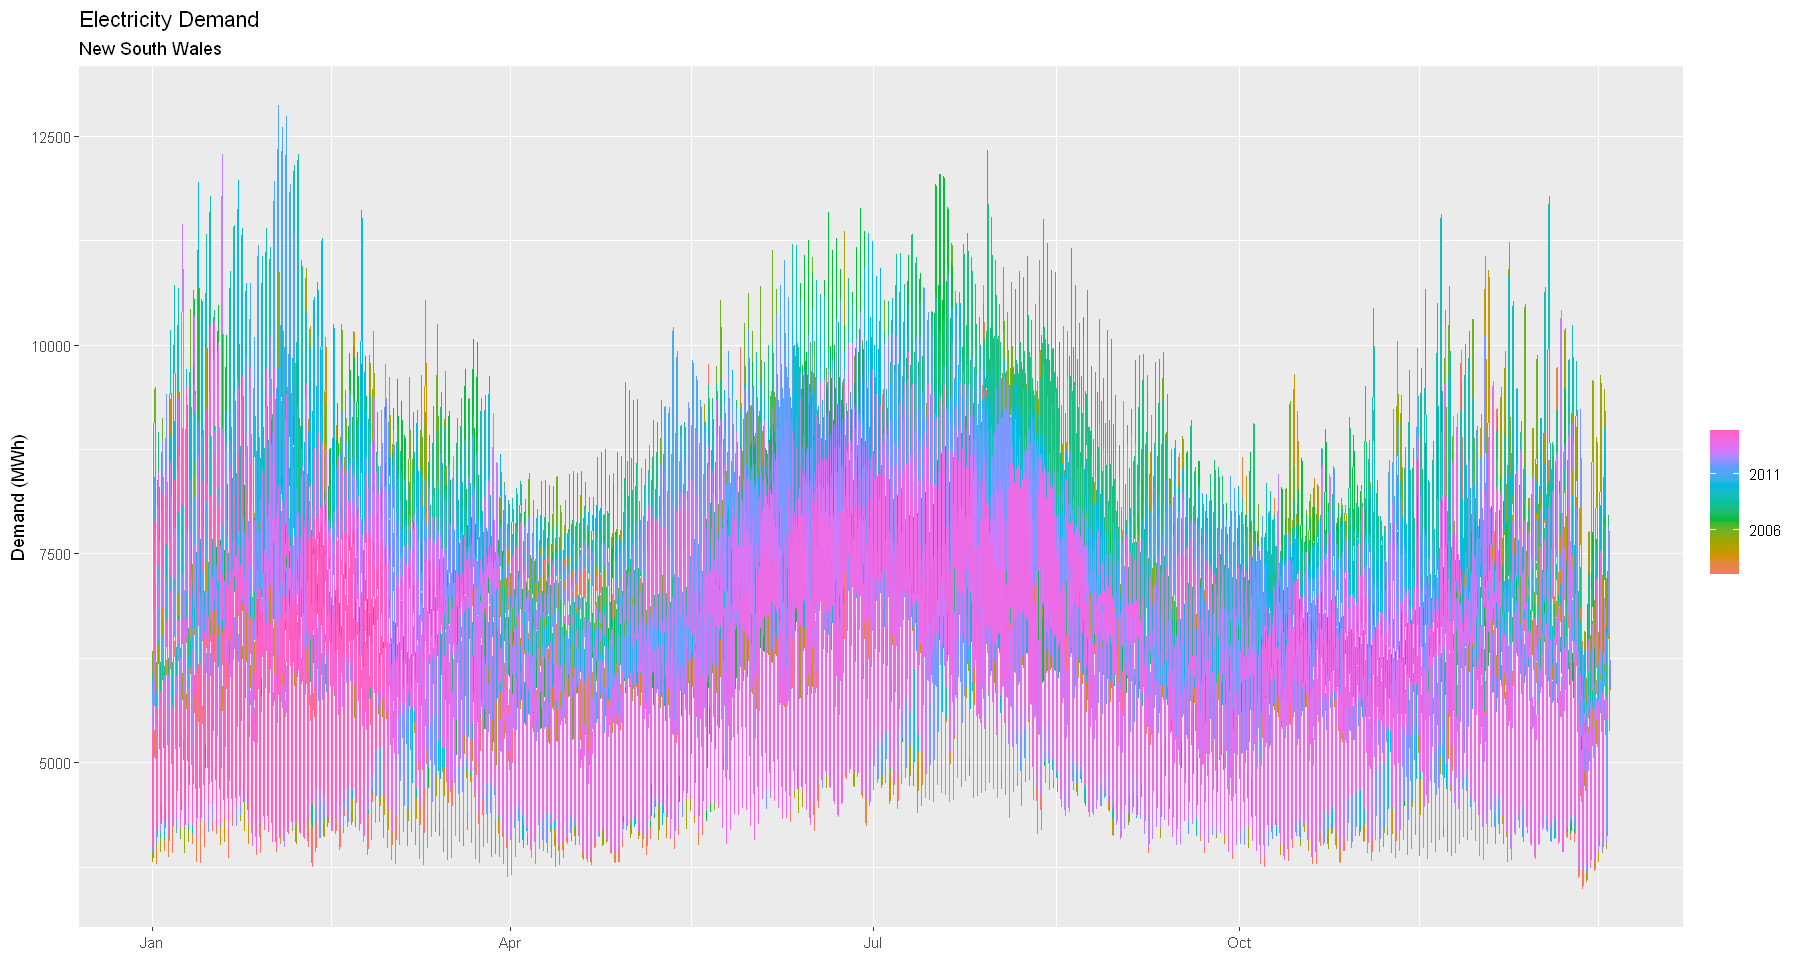

Warning message:
"Removed 48 row(s) containing missing values (geom_path)."


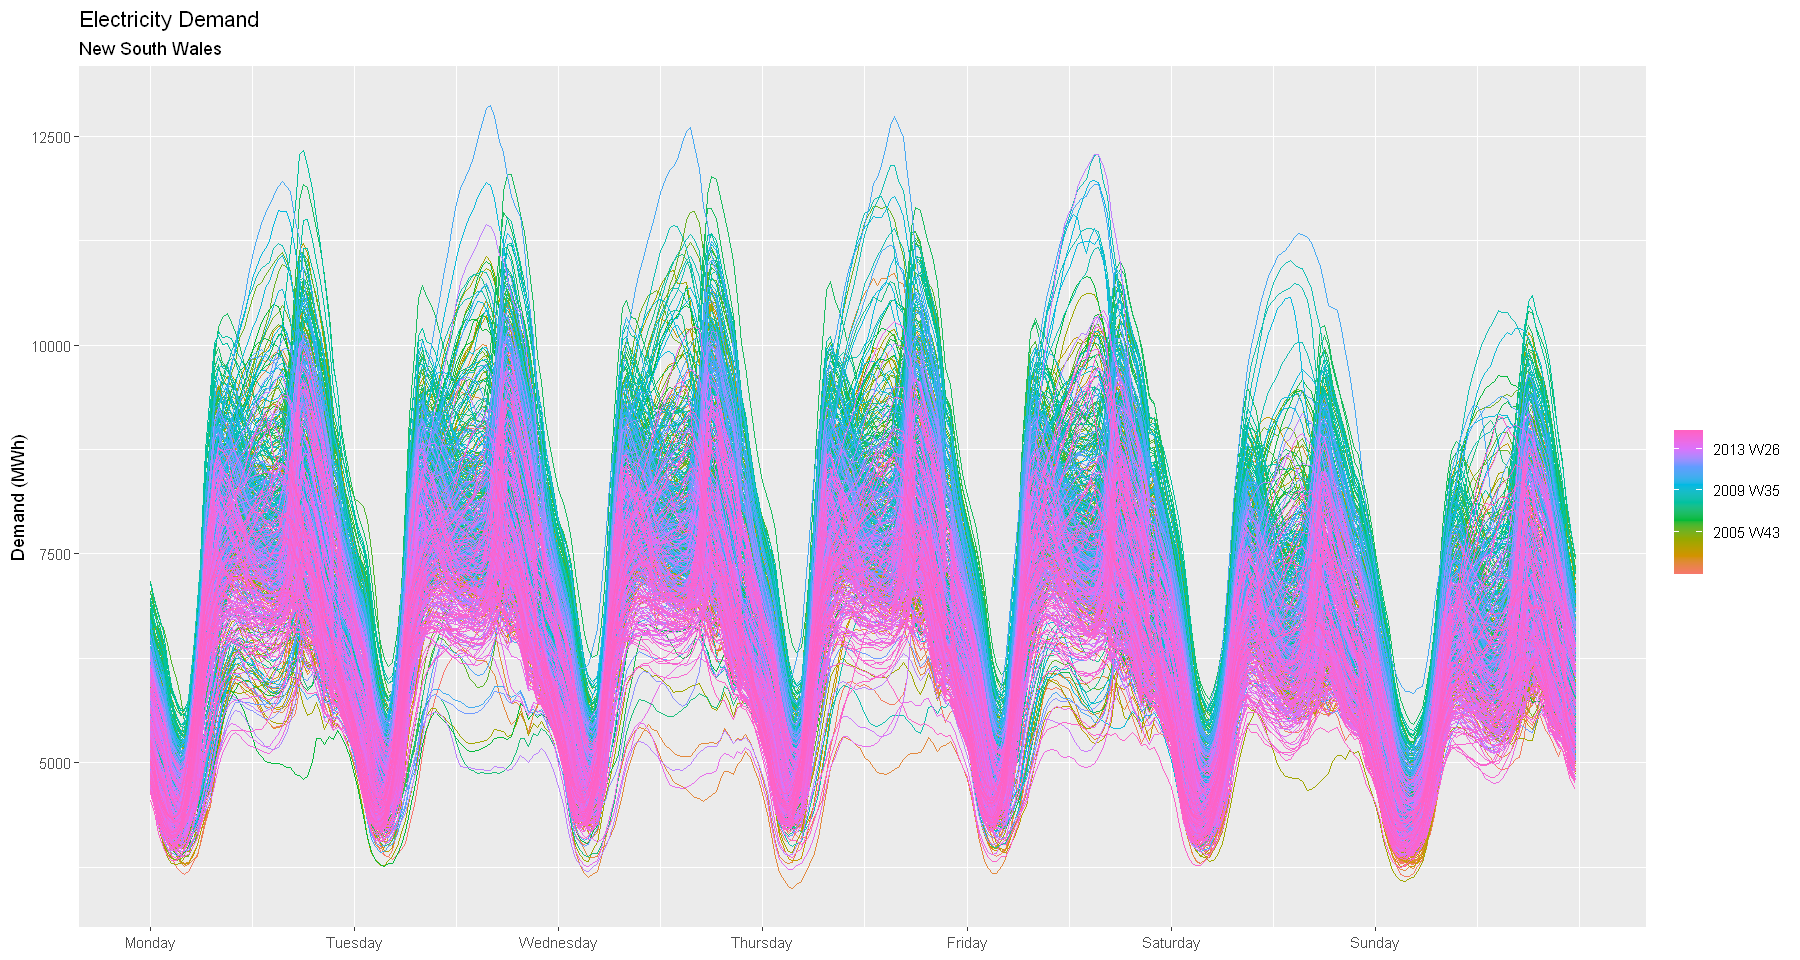

Warning message:
"Removed 48 row(s) containing missing values (geom_path)."


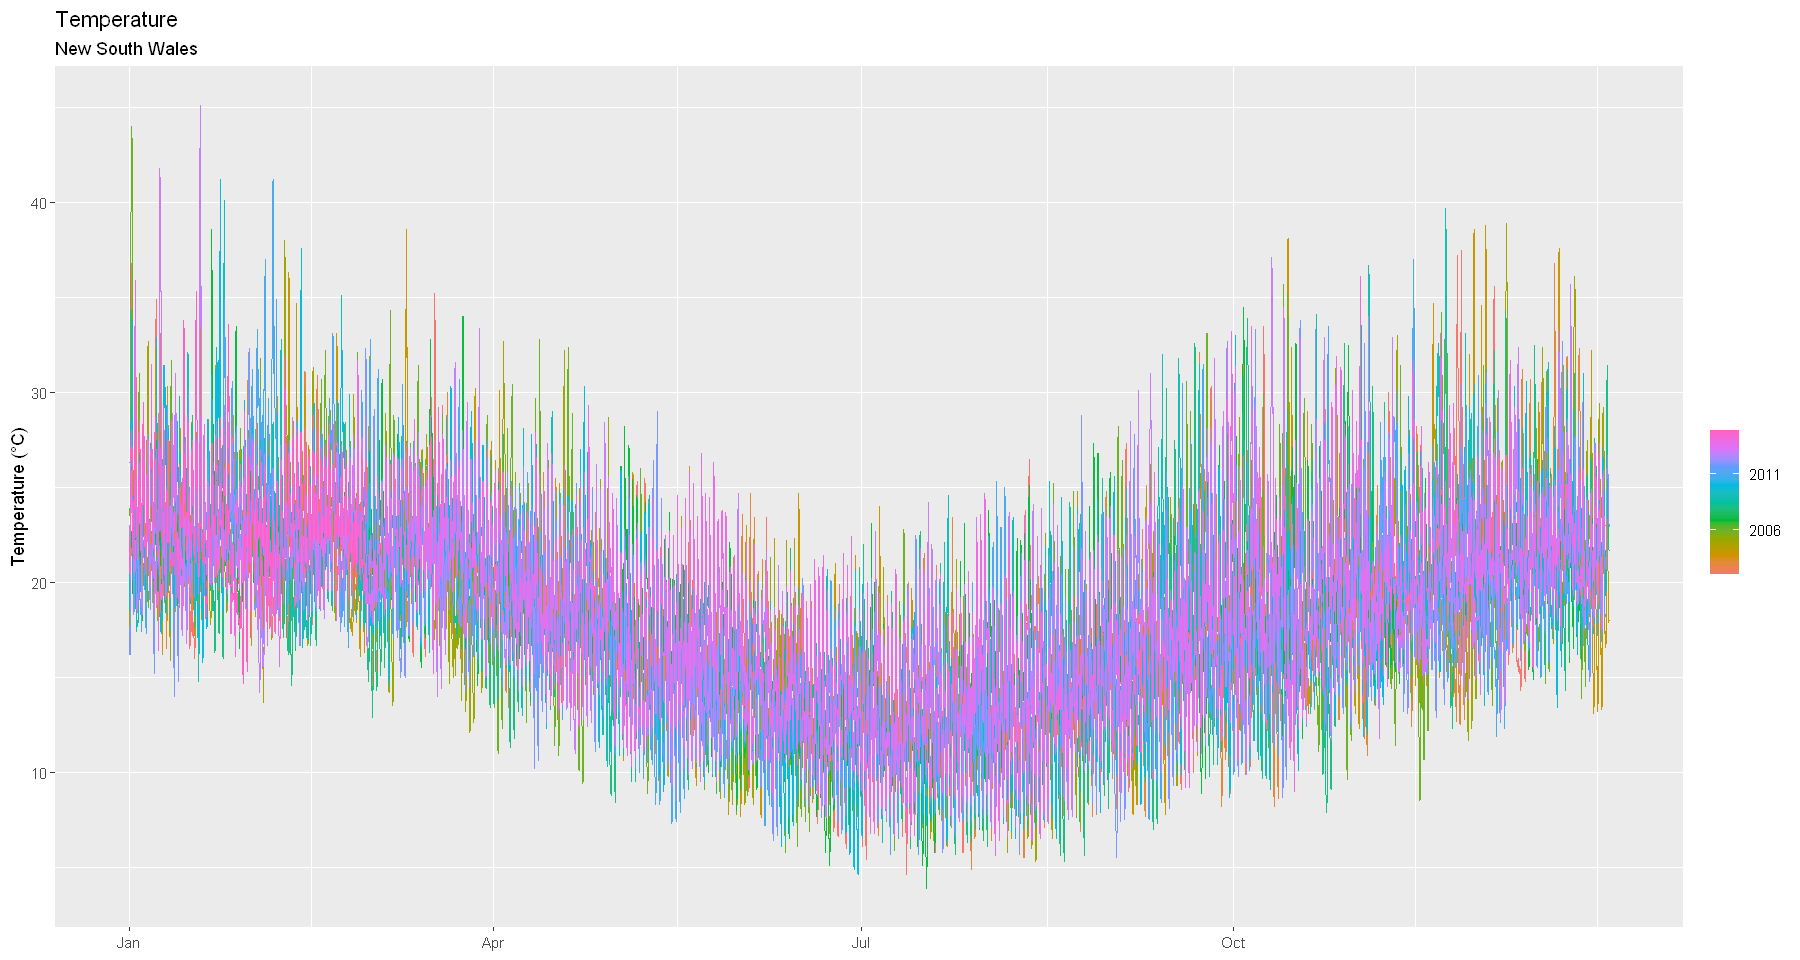

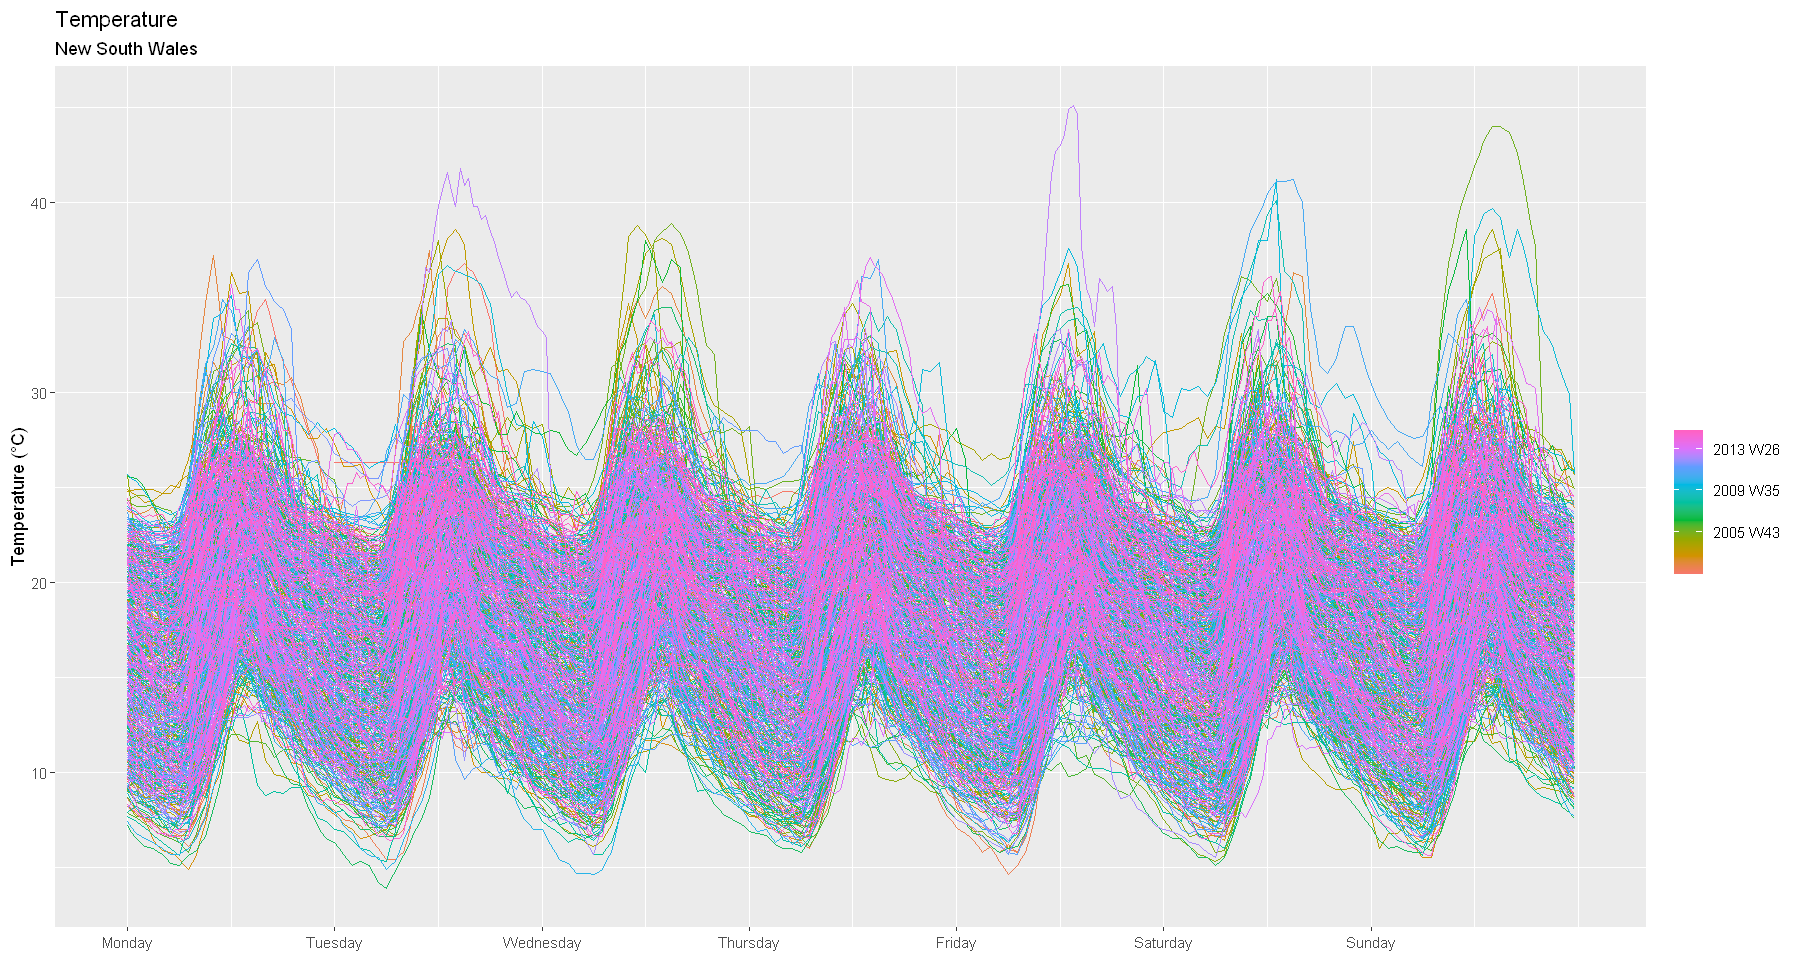

In [5]:
options(repr.plot.height=8, repr.plot.width=15)

nsw_elec %>%
gg_season(Demand, period = "year") +
labs(title = "Electricity Demand",
     subtitle = "New South Wales",
     y = "Demand (MWh)",
     x = NULL
    )

nsw_elec %>%
gg_season(Demand, period = "week") +
labs(title = "Electricity Demand",
     subtitle = "New South Wales",
     y = "Demand (MWh)",
     x = NULL
    )

nsw_elec %>%
gg_season(Temperature, period = "year") +
labs(title = "Temperature",
     subtitle = "New South Wales",
     y = "Temperature (°C)",
     x = NULL
    )

nsw_elec %>%
gg_season(Temperature, period = "week") +
labs(title = "Temperature",
     subtitle = "New South Wales",
     y = "Temperature (°C)",
     x = NULL
    )

## Scatter Plot

"Plotting electricity demand against temperature shows that there is a nonlinear relationship between the two, with demand increasing for low temperatures (due to heating) and increasing for high temperatures (due to cooling)" (https://otexts.com/fpp3/complexseasonality.html).

_The code in the next cell is a modification of the code found in https://otexts.com/fpp3/complexseasonality.html._

Warning message:
"Removed 48 rows containing missing values (geom_point)."


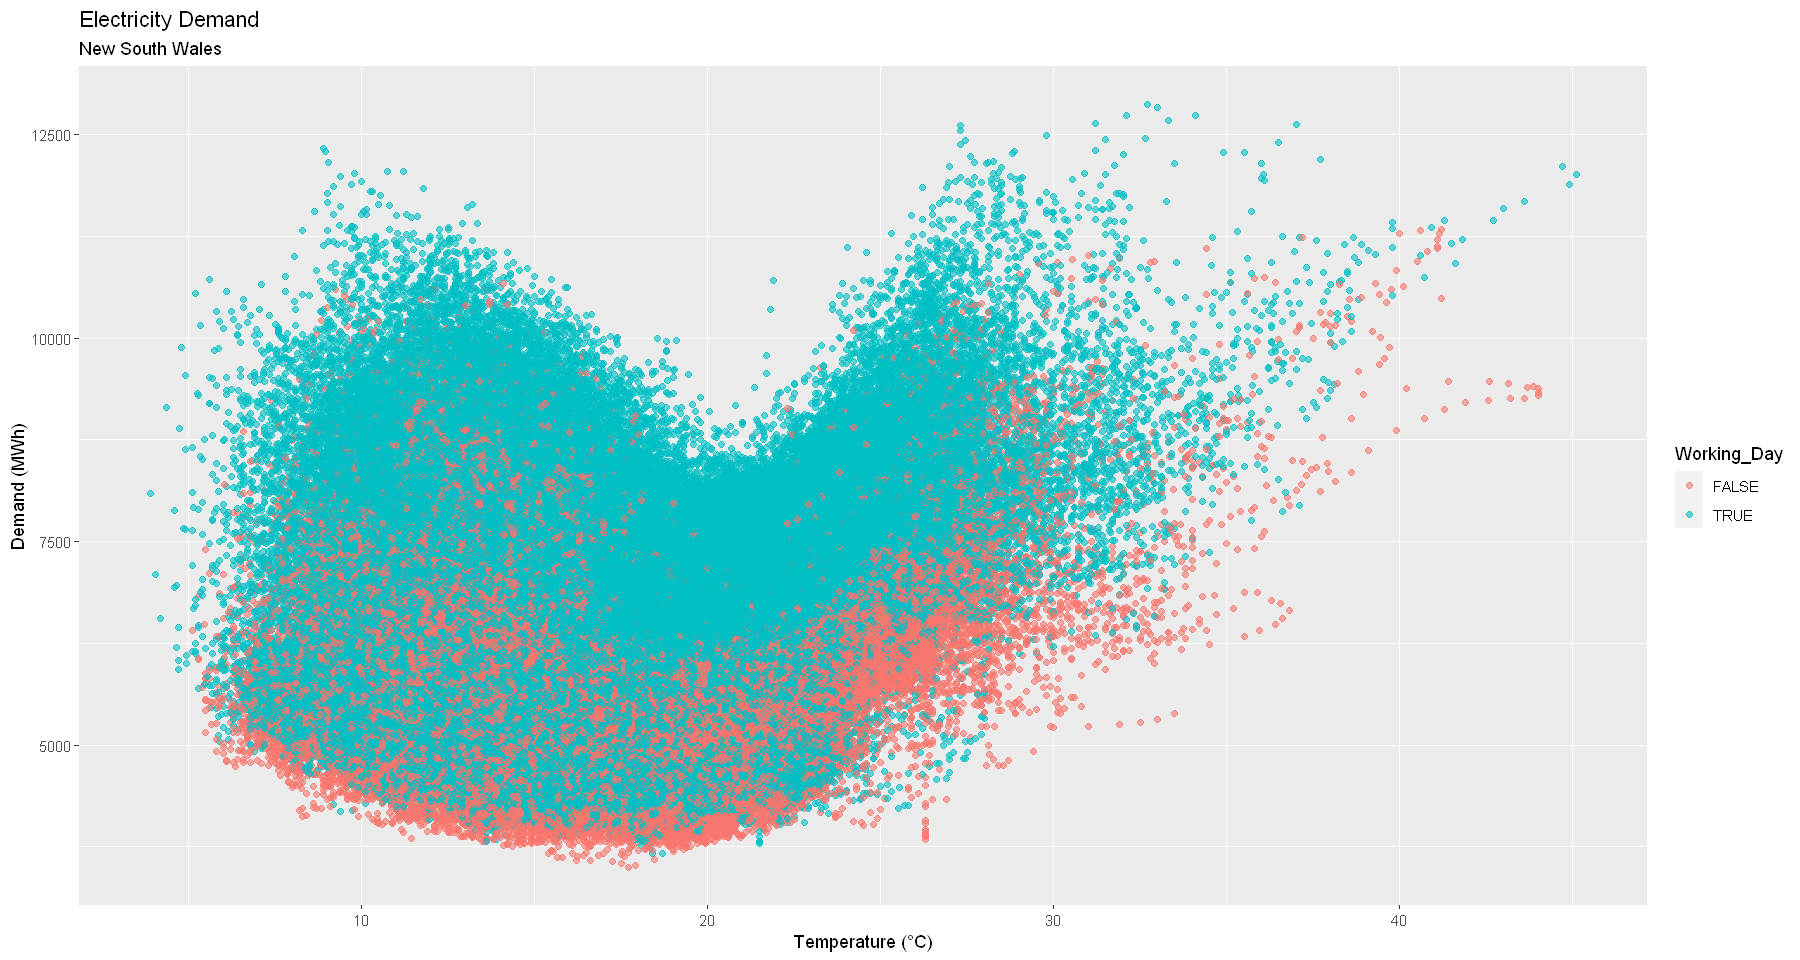

In [6]:
nsw_elec %>%
mutate(DOW = wday(Date, label = TRUE),
       Working_Day = !Holiday & !(DOW %in% c("Sat", "Sun"))
      ) %>%
ggplot(aes(x=Temperature, y=Demand, col=Working_Day)) +
geom_point(alpha = 0.6) +
labs(title = "Electricity Demand",
     subtitle = "New South Wales",
     x="Temperature (°C)", 
     y="Demand (MWh)"
    )

## Model Fitting

A regression model was fitted with a piecewise linear function of temperature (containing a knot at 18 degrees), whether a day is a working day or not, and harmonic regression terms to allow for daily, weekly, and yearly seasonal patterns. The orders of the Fourier terms K were set subjectively. The seasonal periods are 

* Daily: 48 = 2 30-minute periods per hour * 24 hours in a day,
* Weekly: 336 = 2 * 24 * 7 days in a week, and 
* Annual: 17,532 = 2 * 24 * 7 * 365.25/7 weeks in a year. 

PDQ(0,0,0) was used to prevent ARIMA() from automatically handling seasonality (https://otexts.com/fpp3/complexseasonality.html, https://otexts.com/fpp3/weekly.html).

### Fourier Terms K Selection 

* "The K argument to fourier() specifies how many pairs of sine and cosine terms to include. The maximum allowed is $K = \frac{m}{2}$, where $m$ is the seasonal period" (https://otexts.com/fpp3/useful-predictors.html). 
* "The total number of Fourier terms for each seasonal period could be selected to minimise the AICc. 
* However, for high seasonal periods, this tends to over-estimate the number of terms required, so we will use a more subjective choice with
  * \[8\] terms for the daily seasonality, and 
  * 5 for the weekly seasonality" (https://otexts.com/fpp3/complexseasonality.html)
  * 3 for the annual seasonality

In [7]:
# Separate the training and testing sets

elec_train <- nsw_elec %>%
              mutate(DOW = wday(Date, label = TRUE),
                     Working_Day = !Holiday & !(DOW %in% c("Sat", "Sun")),
                     Cooling = pmax(Temperature, 18)
                    ) %>%
              filter_index(. ~ as.character(as_date(paste(year(max(nsw_elec$Date)),"-01-01", sep=""))-1)) %>%
              select(State, Time, Date, DOW, Working_Day, Holiday, Demand, Cooling, Temperature)

elec_train[sample(1:nrow(elec_train), replace=FALSE, size=10),]
max(elec_train$Date)

elec_test <- nsw_elec %>%
             mutate(DOW = wday(Date, label = TRUE),
                    Working_Day = !Holiday & !(DOW %in% c("Sat", "Sun")),
                    Cooling = pmax(Temperature, 18)
                   ) %>%
              filter_index(as.character(as_date(paste(year(max(nsw_elec$Date)),"-01-01", sep=""))) ~ 
                           as.character(max(nsw_elec$Date)-1)) %>%
              select(State, Time, Date, DOW, Working_Day, Holiday, Demand, Cooling, Temperature)

elec_test[sample(1:nrow(elec_test), replace=FALSE, size=10),]
min(elec_test$Date)
max(elec_test$Date)

State,Time,Date,DOW,Working_Day,Holiday,Demand,Cooling,Temperature
<chr>,<dttm>,<date>,<ord>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
NSW,2014-10-24 15:00:00,2014-10-24,Fri,TRUE,FALSE,7236.074,23.0,23.0
NSW,2003-09-10 10:00:00,2003-09-10,Wed,TRUE,FALSE,7412.104,18.0,17.8
NSW,2010-12-19 06:30:00,2010-12-19,Sun,FALSE,FALSE,4927.566,19.1,19.1
NSW,2013-05-26 13:30:00,2013-05-26,Sun,FALSE,FALSE,5850.829,20.2,20.2
NSW,2003-06-23 08:00:00,2003-06-23,Mon,TRUE,FALSE,8704.731,18.0,9.9
NSW,2014-04-29 18:30:00,2014-04-29,Tue,TRUE,FALSE,7442.660,22.4,22.4
NSW,2006-08-17 01:00:00,2006-08-17,Thu,TRUE,FALSE,6922.825,18.0,14.2
NSW,2009-04-30 17:00:00,2009-04-30,Thu,TRUE,FALSE,8128.300,18.0,13.8
NSW,2005-01-05 10:30:00,2005-01-05,Wed,TRUE,FALSE,7672.175,28.5,28.5


[1] "2014-12-31"

State,Time,Date,DOW,Working_Day,Holiday,Demand,Cooling,Temperature
<chr>,<dttm>,<date>,<ord>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
NSW,2015-01-30 15:00:00,2015-01-30,Fri,TRUE,FALSE,6602.887,26.1,26.1
NSW,2015-02-14 01:00:00,2015-02-14,Sat,FALSE,FALSE,4846.140,21.7,21.7
NSW,2015-02-01 20:00:00,2015-02-01,Sun,FALSE,FALSE,5984.741,21.5,21.5
NSW,2015-01-16 12:00:00,2015-01-16,Fri,TRUE,FALSE,7904.004,26.5,26.5
NSW,2015-01-18 23:00:00,2015-01-18,Sun,FALSE,FALSE,5335.584,22.9,22.9
NSW,2015-01-23 22:30:00,2015-01-23,Fri,TRUE,FALSE,6593.868,24.4,24.4
NSW,2015-02-22 14:00:00,2015-02-22,Sun,FALSE,FALSE,6484.962,26.8,26.8
NSW,2015-01-14 11:00:00,2015-01-14,Wed,TRUE,FALSE,8332.701,31.0,31.0
NSW,2015-01-26 10:00:00,2015-01-26,Mon,FALSE,TRUE,5991.807,19.8,19.8


[1] "2015-01-01"

[1] "2015-02-28"

In [8]:
fit <- elec_train %>%
       model(ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + 
                   PDQ(0, 0, 0) +
                   fourier(period = 24 * 2, K = 8) +
                   fourier(period = 24 * 2 * 7, K = 5) +
                   fourier(period = 24 * 2 * 7 * 365.25/7, K = 3)
                  )
            )
tidy(fit)

State,.model,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",ar1,0.7491076971,3.434148e-03,218.13495534,0.000000e+00
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",ar2,0.6953660704,5.242915e-03,132.62965546,0.000000e+00
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",ar3,-0.5561060771,3.639671e-03,-152.79021347,0.000000e+00
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",ar4,-0.0145806183,2.228181e-03,-6.54373280,6.012835e-11
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",ma1,-0.0812755648,2.697409e-03,-30.13097951,4.700997e-199
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",ma2,-0.8828097784,2.666856e-03,-331.03011119,0.000000e+00
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",Cooling,0.0057029620,1.606564e-04,35.49788716,3.013242e-275
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",Temperature,-0.0034530833,1.373324e-04,-25.14397195,2.551574e-139
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",Working_DayTRUE,-0.0001549114,3.090469e-04,-0.50125527,6.161920e-01


## Model Interpretation

* For every 1 unit increase in temperature, the demand for electricity for cooling increased by 0.57% $= 100 * (e^{0.0057029620}-1)$.
* For every 1 unit decrease in temperature, the demand for electricity for heating increased by 0.34% $= 100 * (e^{-0.0034530833} -1)$.
* There was no evidence in the data to conclude that there was significant difference in demand between days when people worked and days when people did not. The relationship might have already been accounted for by weekly seasonality.
* There was evidence to conclude that demand for electricity had daily and weekly seasonalities.
* However, there was no evidenvce in the data to conclude that demand for electricity had annual seasonality. The annual seasonality might have already been accounted for by the relationships between (heating and cooling) temperatures and demand.

## Selecting Predictors

### Scatterplots

"A common approach that is __not recommended__ is to plot the forecast variable against a particular predictor and if there is no noticeable relationship, drop that predictor from the model. This is invalid because it is __not always possible to see the relationship from a scatterplot, especially when the effects of other predictors have not been accounted for__.

### $p$-values

Another common approach which is also __invalid__ is to do a multiple linear regression on all the predictors and disregard all variables whose $p$-values are greater than 0.05. To start with, __statistical significance does not always indicate predictive value__. Even if forecasting is not the goal, this is not a good strategy because the __$p$-values can be misleading when two or more predictors are correlated with each other__."

### $R^2$

$R^2$ \[...\] is not a good measure of the predictive ability of a model. \[...\] __Adding any variable tends to increase the value of $R^2$, even if that variable is irrelevant.__ \[... Using $R^2$\] will lead to overfitting.

### AICc, AIC, or CV

___The use of AICc, AIC, or CV statistics in selecting the final model is recommended.___ (https://otexts.com/fpp3/selecting-predictors.html)

## Residual Diagnostics

The model was a crude model for a complicated process. The residuals demonstrated that there was information not captured. (https://otexts.com/fpp3/complexseasonality.html)

The result of the Ljung-Box test was significant (i.e., the $p$-value was relatively small). Therefore, the residuals were distinguishable from a white noise series. (https://otexts.com/fpp3/diagnostics.html)

State,.model,lb_stat,lb_pvalue
<chr>,<chr>,<dbl>,<dbl>
NSW,"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",5558.781,0


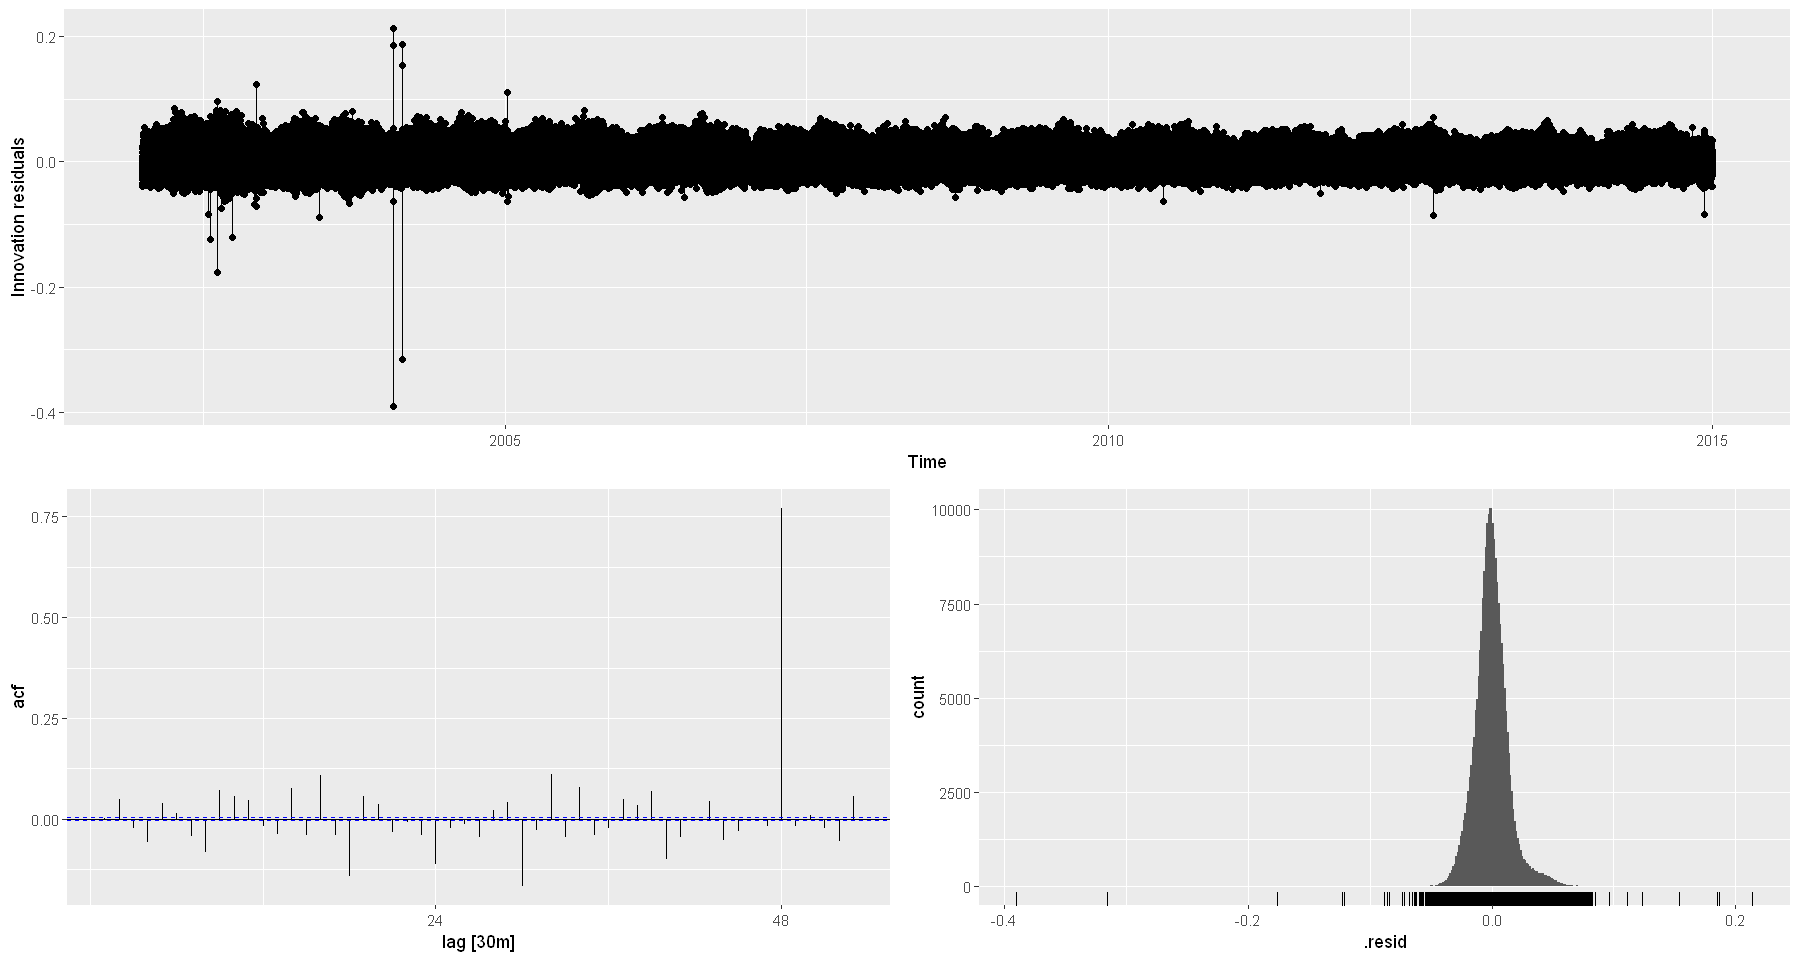

In [9]:
fit %>% gg_tsresiduals()
augment(fit) %>% features(.innov, ljung_box, lag=10)

## Forecasting

"Forecasting with \[a dynamic harmonic regression model\] is difficult because it \[requires\] future values of the predictor variables. Future values of the Fourier terms are easy to compute, but future temperatures are, of course, unknown. If \[the analytics objective is only\] in forecasting up to a week ahead, \[...\] temperature forecasts obtained from a meteorological model \[could be used\]." It is also reasonable to assume that temperatures a few days into the future are not too different from temperatures of the most recent few days. Thus, using "a repeat of the last two days of temperatures to generate future possible demand values" is reasonable (https://otexts.com/fpp3/complexseasonality.html).

The observations from the first two months of 2015 were used to evaluate the forecast accuracy of the dynamic harmonic regression model. The demand forecasts seemed reasonable but seemed to serially overforecast, and to serially underforecast.

In [10]:
elec_fc <- fit %>%
           forecast(new_data = elec_test)

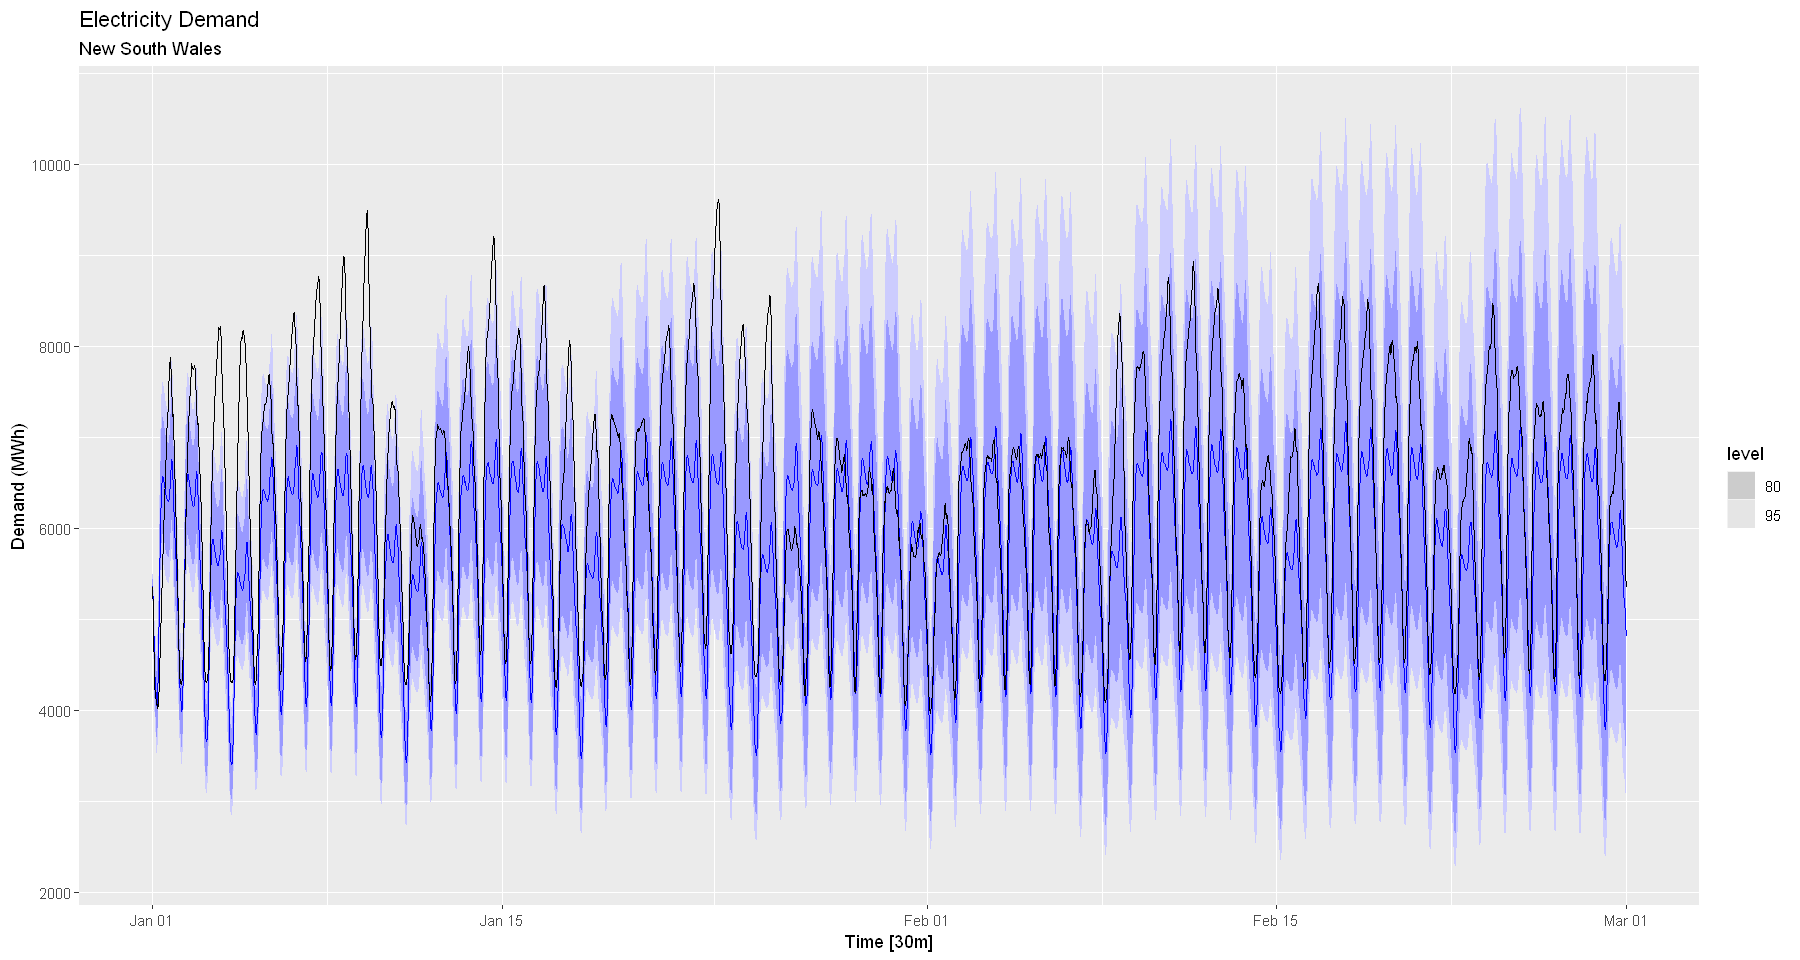

In [11]:
autoplot(elec_fc, elec_test) + 
labs(title = "Electricity Demand",
     subtitle = "New South Wales",
     y="Demand (MWh)",
     x="Time [30m]"
    )

## Error Diagnostics

The model generally underforecasted from the first week of January to the third week, and from the second week of February. From the fourth week of January to the first of February, it overforecasted.

Generally, the model underforecasted the demand for electricity. The forecast errors demonstrated patterns that could still be accounted for.

.model,State,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ARIMA(log1p(Demand) ~ Cooling + Temperature + Working_Day + PDQ(0, 0, 0) + fourier(period = 24 * 2, K = 8) + fourier(period = 24 * 2 * 7, K = 5) + fourier(period = 24 * 2 * 7 * 365.25/7, K = 3))",NSW,Test,645.6921,925.4582,714.4148,9.24277,10.46489,NaN,NaN,0.9847535


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



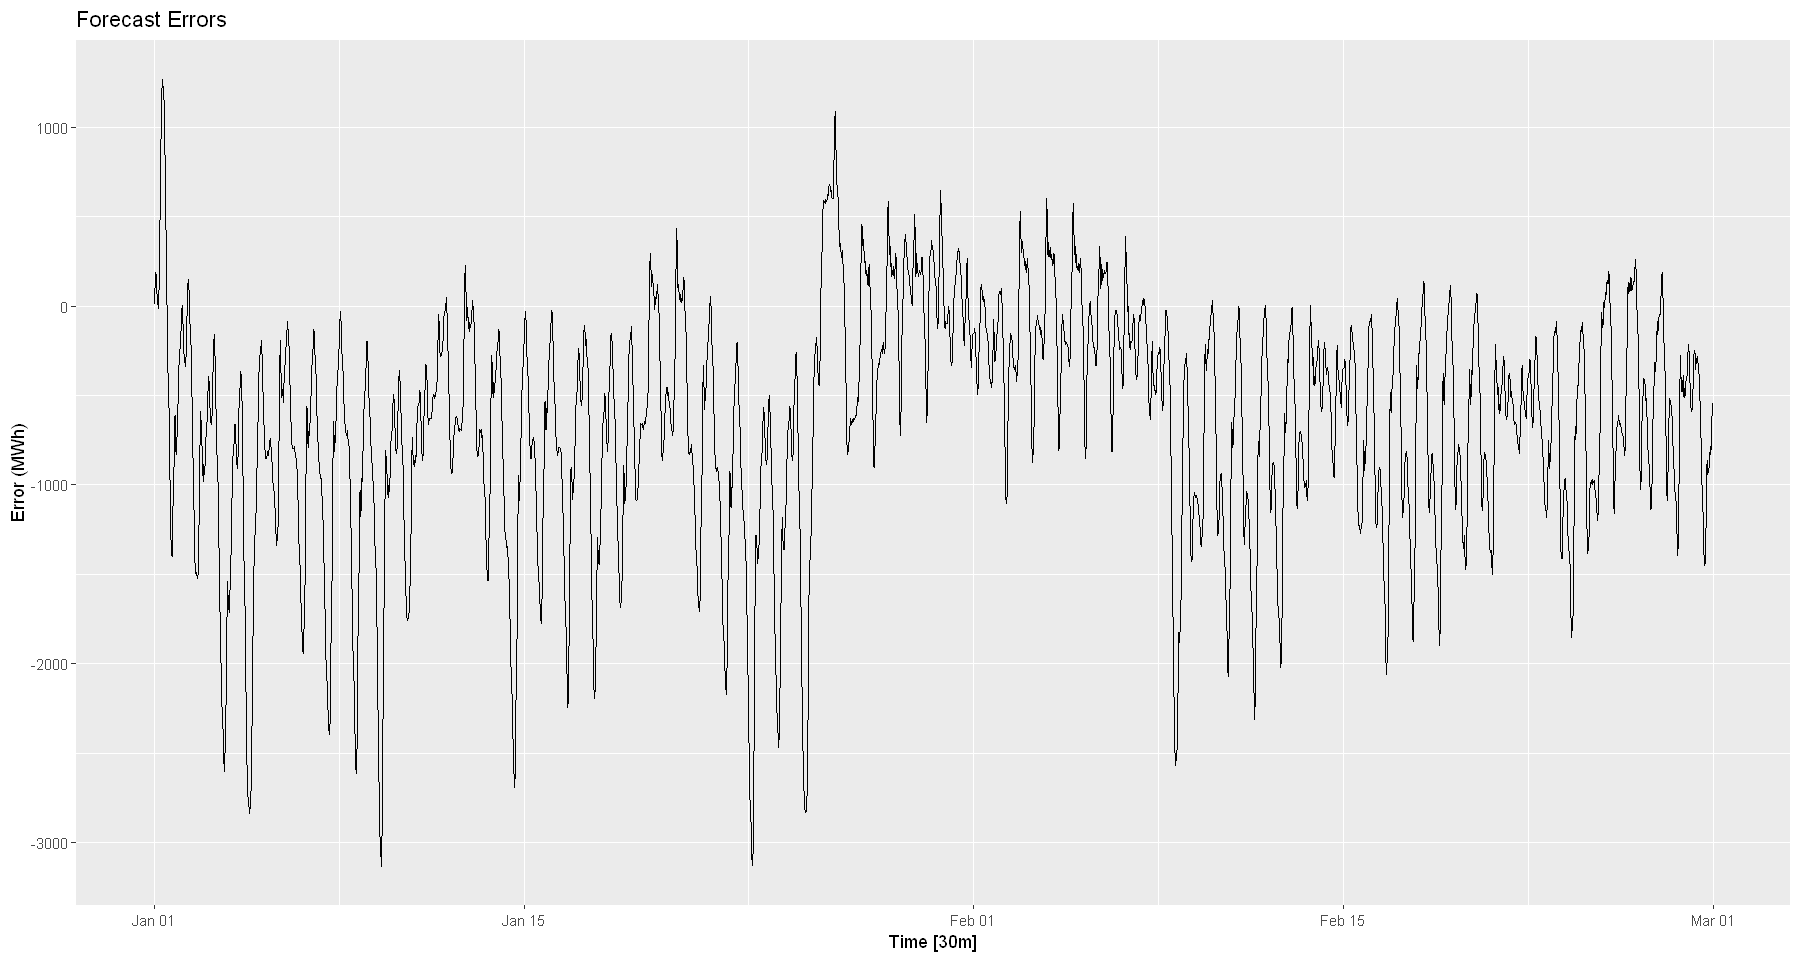

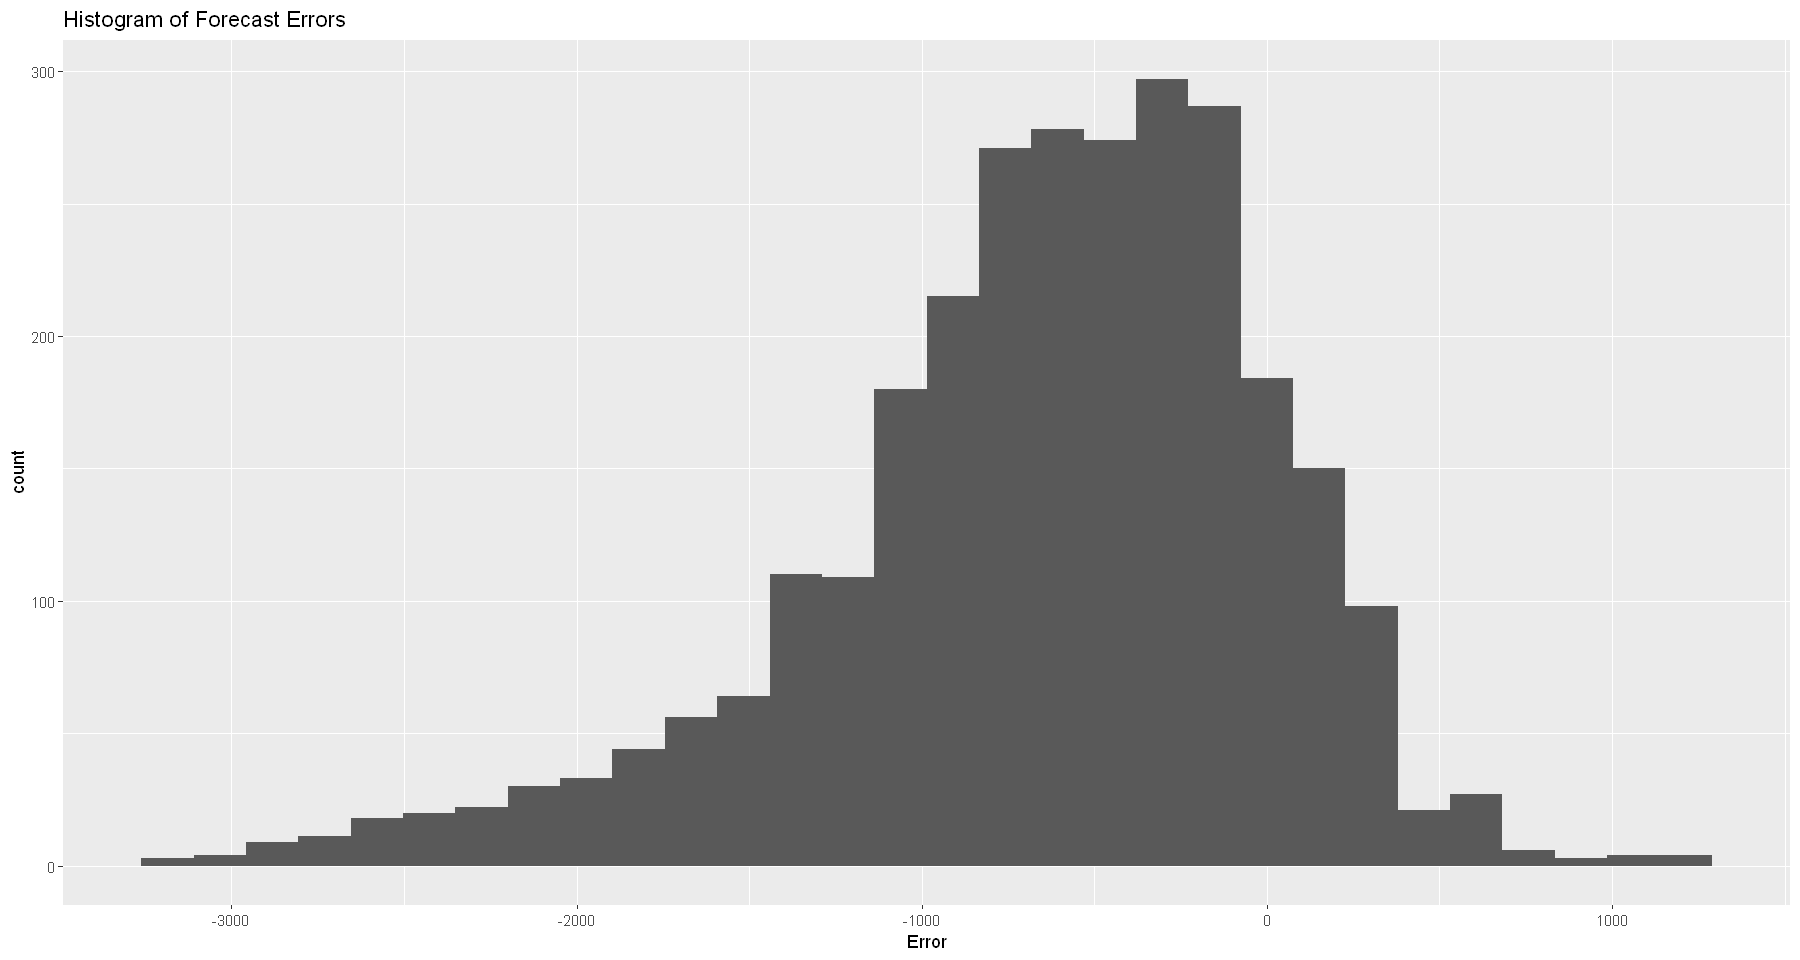

lb_stat,lb_pvalue
<dbl>,<dbl>
15786.03,0


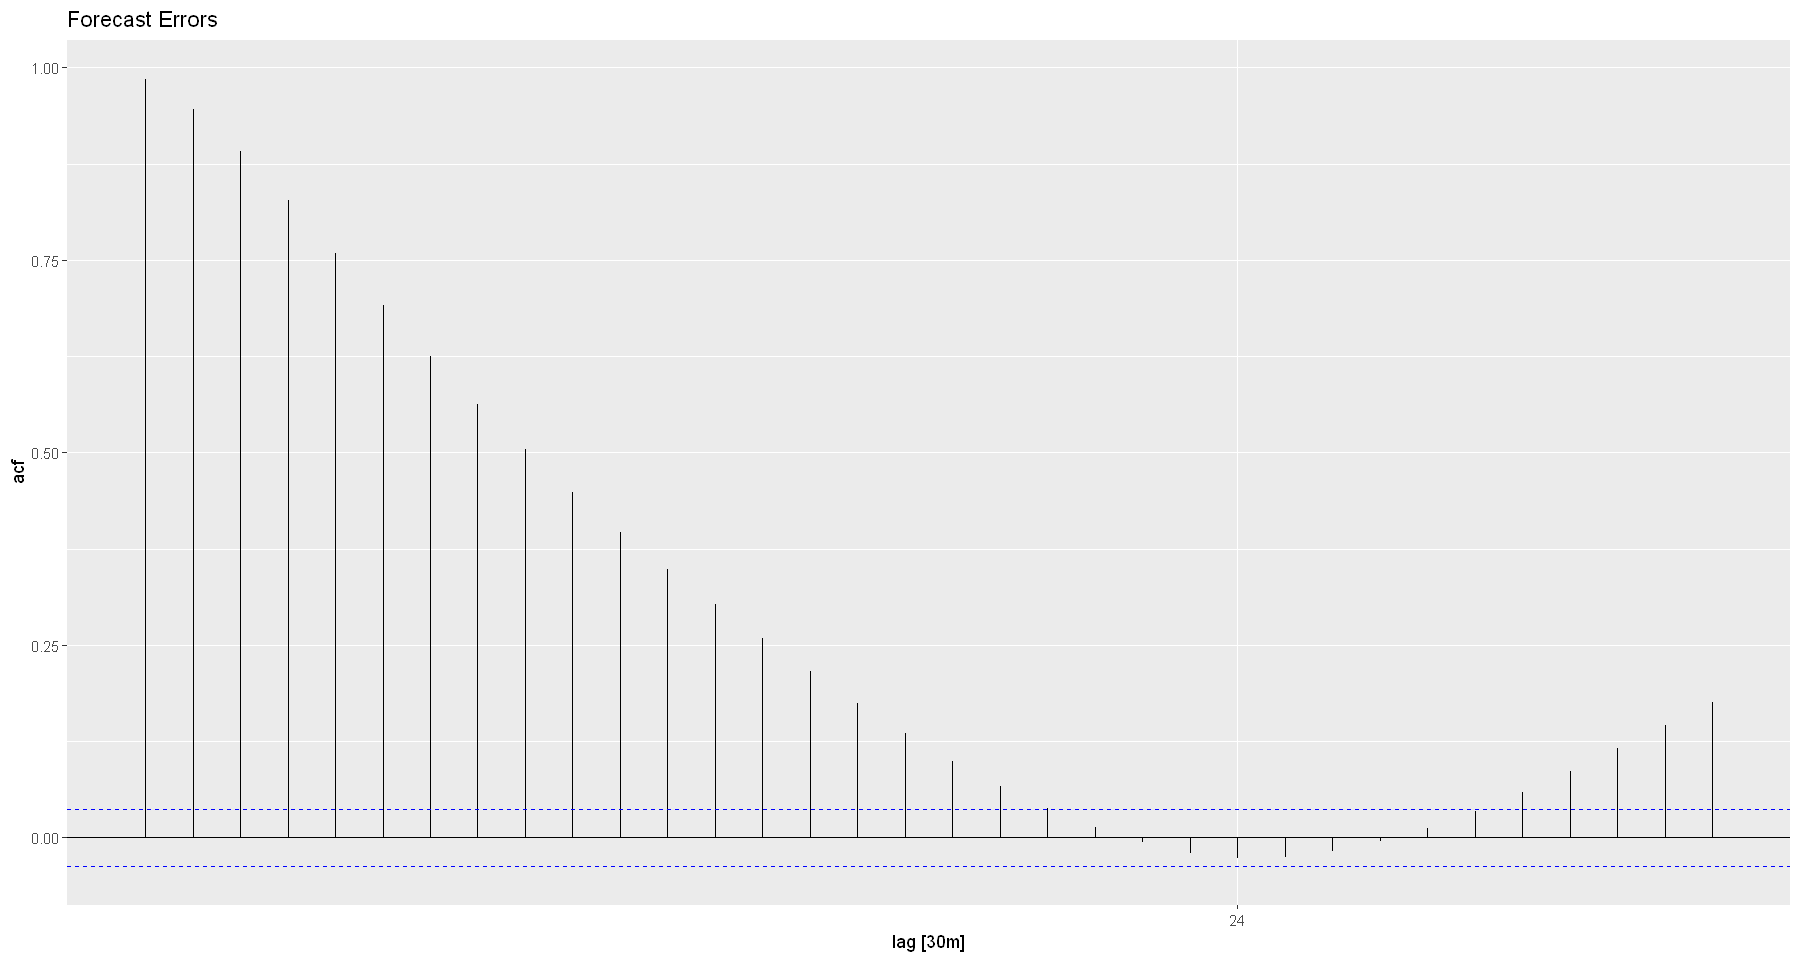

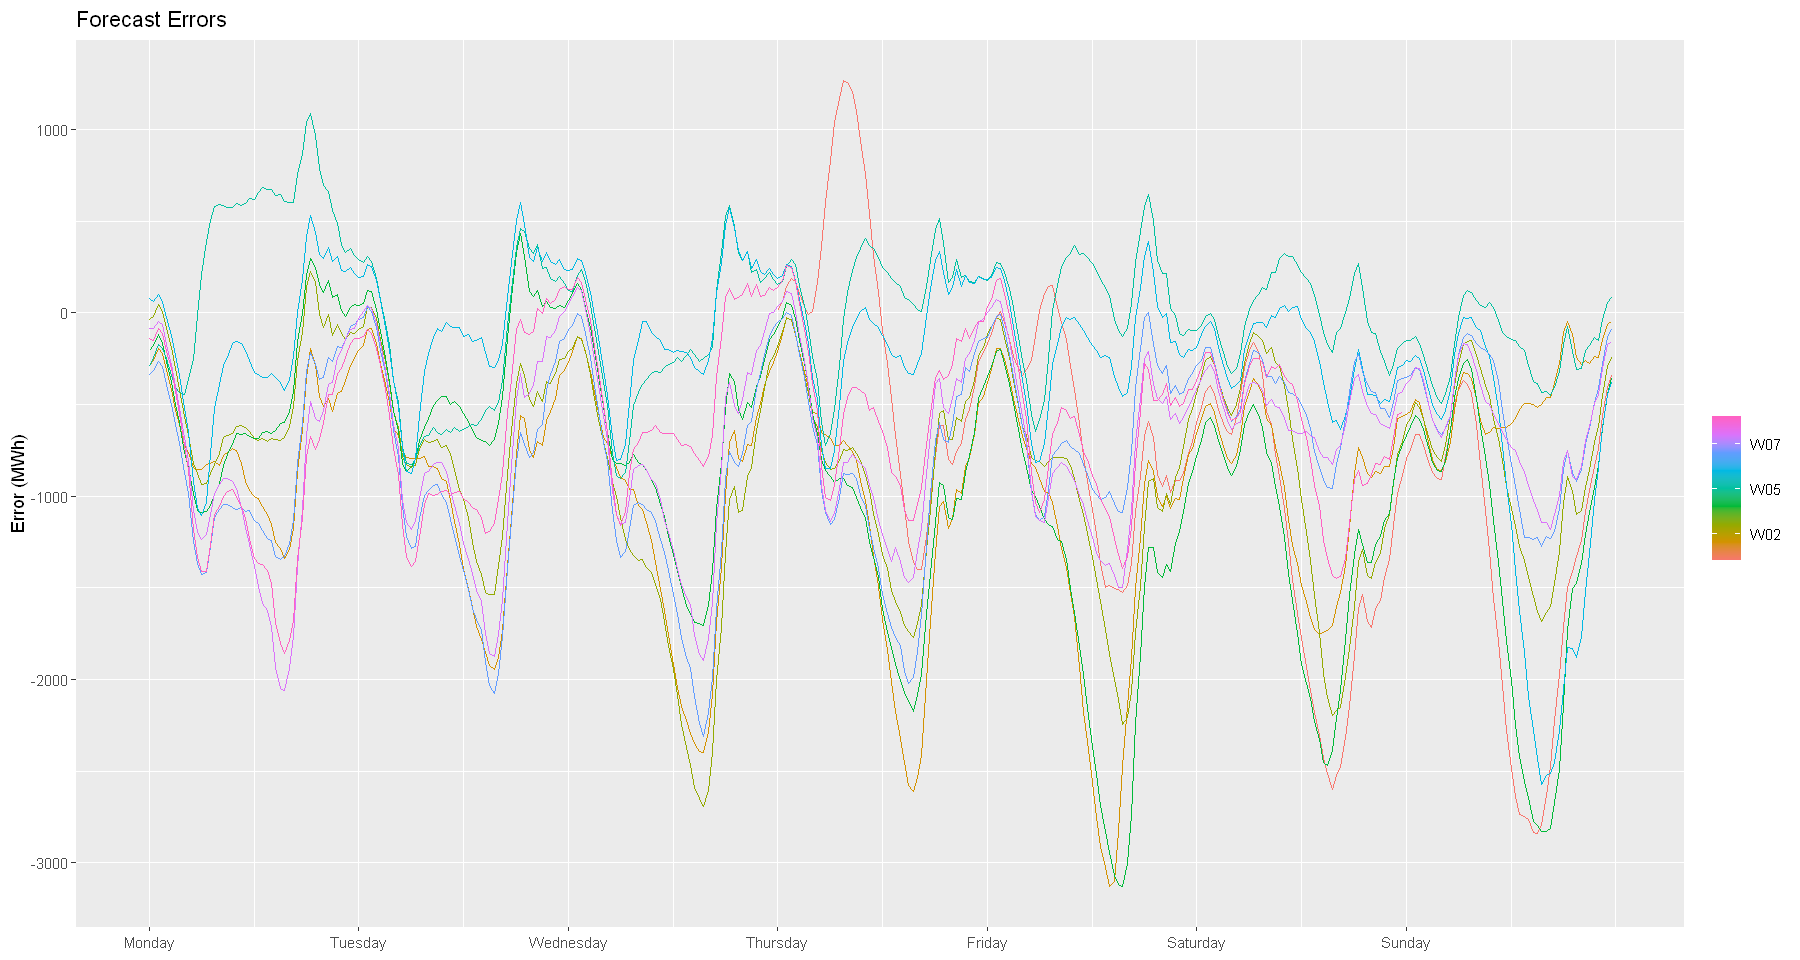

In [12]:
elec_fce <- elec_test %>% transmute(Error = elec_fc$.mean - elec_test$Demand)

accuracy(elec_fc, elec_test)

elec_fce %>% 
autoplot(Error) + 
labs(title = "Forecast Errors",
     y = "Error (MWh)",
     x = "Time [30m]"
    )

elec_fce %>% ggplot(aes(x = Error)) +
geom_histogram() +
labs(title = "Histogram of Forecast Errors")

elec_fce %>% ACF(Error) %>%
autoplot() +
labs(title = "Forecast Errors")

elec_fce %>% features(Error, ljung_box, lag=10)

elec_fce %>%
gg_season(Error, period = "week") +
labs(title = "Forecast Errors",
     y = "Error (MWh)",
     x = NULL
    )

## Conclusion

"More sophisticated versions of this model which provide much better forecasts are described in Hyndman & Fan (2010) and Fan & Hyndman (2012)" (https://otexts.com/fpp3/complexseasonality.html)

Fan, S., & Hyndman, R. J. (2012). Short-term load forecasting based on a semi-parametric additive model. IEEE Transactions on Power Systems, 27(1), 134–141.

Hyndman, R. J., & Fan, S. (2010). Density forecasting for long-term peak electricity demand. IEEE Transactions on Power Systems, 25(2), 1142–1153.